- in our original agenda this week we try different covariance estimation method
- but I think we'd better go directly to regression model
- then we can save some time for further more complicate machine learning models


- this week we focus on the most simple linear regression without regularization

In [57]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
import  sklearn.preprocessing
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [50]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM 

16

- number of cores, set this number according to your computer

- sample period

In [4]:
period = 4096

- get all of the days

In [5]:
import dask
from dask import compute, delayed

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 915

915

In [12]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [3]:
product_list = ["rb", "hc", "i", "j", "jm"]

In [13]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]

In [14]:
signal_list

['trade.imb.4096',
 'total.trade.imb.4096',
 'nr.4096',
 'dbook.4096',
 'range.pos.4096',
 'price.osci.4096',
 'ma.dif.10.4096',
 'kdj.k.4096',
 'kdj.j.4096',
 'trade.imb.range.4096',
 'total.trade.imb.range.4096',
 'nr.range.4096',
 'dbook.range.4096',
 'range.pos.range.4096',
 'price.osci.range.4096',
 'ma.dif.10.range.4096',
 'kdj.k.range.4096',
 'kdj.j.range.4096',
 'trade.imb.std.4096',
 'total.trade.imb.std.4096',
 'nr.std.4096',
 'dbook.std.4096',
 'range.pos.std.4096',
 'price.osci.std.4096',
 'ma.dif.10.std.4096',
 'kdj.k.std.4096',
 'kdj.j.std.4096',
 'trade.imb.volume.open.ratio.4096',
 'total.trade.imb.volume.open.ratio.4096',
 'nr.volume.open.ratio.4096',
 'dbook.volume.open.ratio.4096',
 'range.pos.volume.open.ratio.4096',
 'price.osci.volume.open.ratio.4096',
 'ma.dif.10.volume.open.ratio.4096',
 'kdj.k.volume.open.ratio.4096',
 'kdj.j.volume.open.ratio.4096',
 'trade.imb.trend.index.4096',
 'total.trade.imb.trend.index.4096',
 'nr.trend.index.4096',
 'dbook.trend.index.

In [15]:
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])

array(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
       'range.pos.4096', 'price.osci.4096', 'ma.dif.10.4096',
       'kdj.k.4096', 'kdj.j.4096', 'trade.imb.range.4096',
       'total.trade.imb.range.4096', 'nr.range.4096', 'dbook.range.4096',
       'range.pos.range.4096', 'price.osci.range.4096',
       'ma.dif.10.range.4096', 'kdj.k.range.4096', 'kdj.j.range.4096',
       'trade.imb.std.4096', 'total.trade.imb.std.4096', 'nr.std.4096',
       'dbook.std.4096', 'range.pos.std.4096', 'price.osci.std.4096',
       'ma.dif.10.std.4096', 'kdj.k.std.4096', 'kdj.j.std.4096',
       'trade.imb.volume.open.ratio.4096',
       'total.trade.imb.volume.open.ratio.4096',
       'nr.volume.open.ratio.4096', 'dbook.volume.open.ratio.4096',
       'range.pos.volume.open.ratio.4096',
       'price.osci.volume.open.ratio.4096',
       'ma.dif.10.volume.open.ratio.4096', 'kdj.k.volume.open.ratio.4096',
       'kdj.j.volume.open.ratio.4096', 'trade.imb.trend.index.4096',
      

In [16]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[9])

- let's begin with week 7 

- to build up a regression model, we need predictors and response variables
- the previous signals can be predictors
- now we need to create a response

- for example, we can use future log returns as response

- here fcum means the future sum of data
- for example

In [16]:
sample_y = fcum(data["ret"], period)

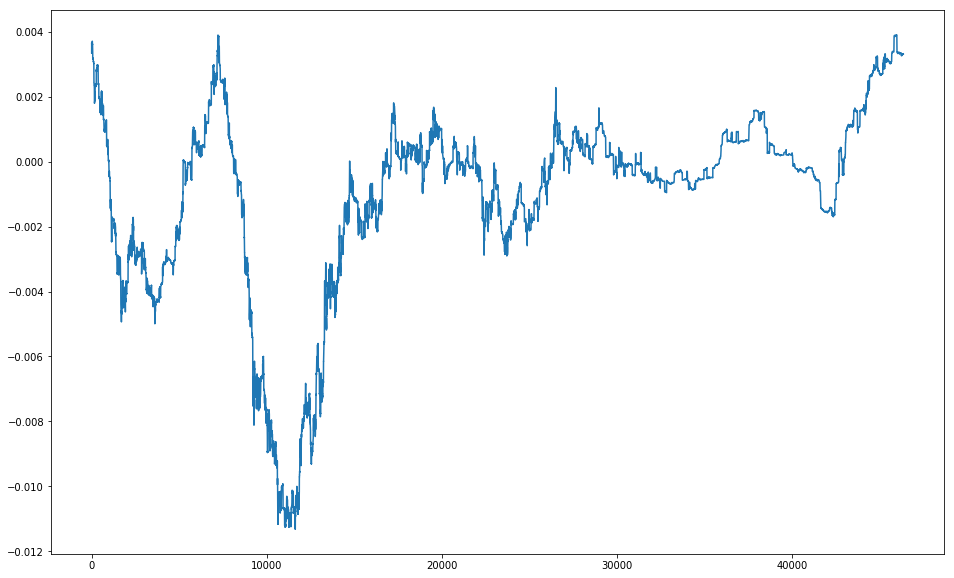

In [17]:
plt.figure(1, figsize=(16, 10))
plt.plot(sample_y[data["good"]].values);

In [18]:
kurtosis(sample_y[data["good"]], fisher=False)
## 5.622609589565017

5.622609589565017

- the response has quite high kurtosis, it means the response has fat tails


- we can check the result

In [19]:
np.sum(data["ret"][3000:(3000+period)])
## 0.0014536186018068169

0.0014536186018068169

In [20]:
sample_y[2999]
## 0.0014536186018068169

0.0014536186018068169

- so fcum means future sume, and ys is the future price return

- now we create directory for this response signal

In [22]:
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
    
y1 = foctor_ret_period()



In [23]:
for product in product_list:
    create_signal_path(y1, product, HEAD_PATH);

d:/intern/tmp pkl/rb/ret.1024
d:/intern/tmp pkl/rb/ret.2048
d:/intern/tmp pkl/rb/ret.4096
d:/intern/tmp pkl/hc/ret.1024
d:/intern/tmp pkl/hc/ret.2048
d:/intern/tmp pkl/hc/ret.4096
d:/intern/tmp pkl/i/ret.1024
d:/intern/tmp pkl/i/ret.2048
d:/intern/tmp pkl/i/ret.4096
d:/intern/tmp pkl/j/ret.1024
d:/intern/tmp pkl/j/ret.2048
d:/intern/tmp pkl/j/ret.4096
d:/intern/tmp pkl/jm/ret.1024
d:/intern/tmp pkl/jm/ret.2048
d:/intern/tmp pkl/jm/ret.4096


In [26]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y1, product=product, HEAD_PATH=HEAD_PATH)
;



Wall time: 14min 21s


- now let's see how it looks like

In [27]:
%%time
for product in product_list:
    parLapply(CORE_NUM, ["ret.4096"], par_get_all_signal, file_list=all_dates, product=product, period=4096, HEAD_PATH=HEAD_PATH);
    

Wall time: 14min 6s


In [25]:
all_signal = load(HEAD_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")

- plot the signal

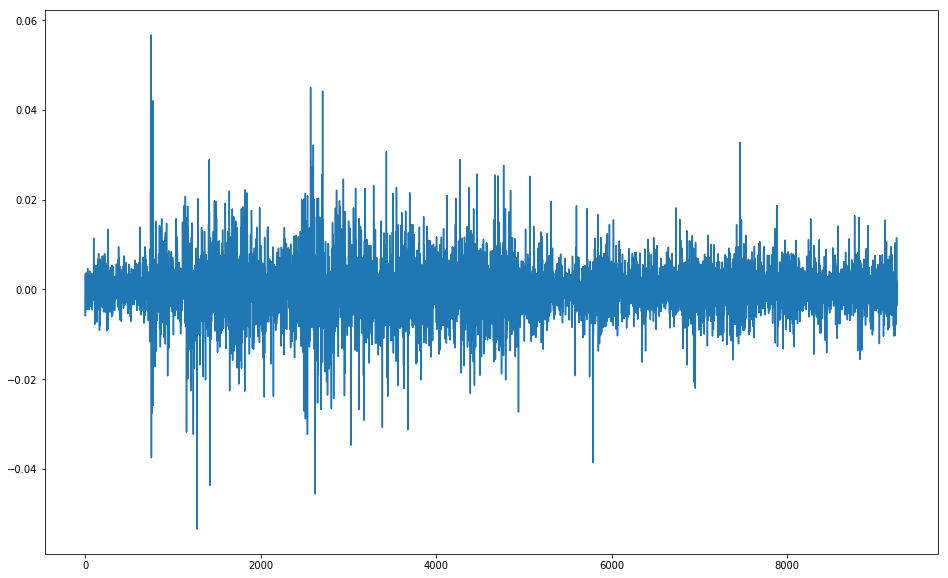

In [21]:
plt.figure(1, figsize=(16, 10))
plt.plot(all_signal);

- check the statistics of the signal

In [14]:
print("kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))
## kurtosis= 11.896707071146905  skew= -0.15047762629522704
## we can see it has very fat tails
## usually we don't adjust for response because we want to profit from the fat tails

kurtosis= 11.896707071146905  skew= -0.15047762629522704


- let's try some vanish signal

kurtosis= 5.240453925443156  skew= -0.015080391934041855


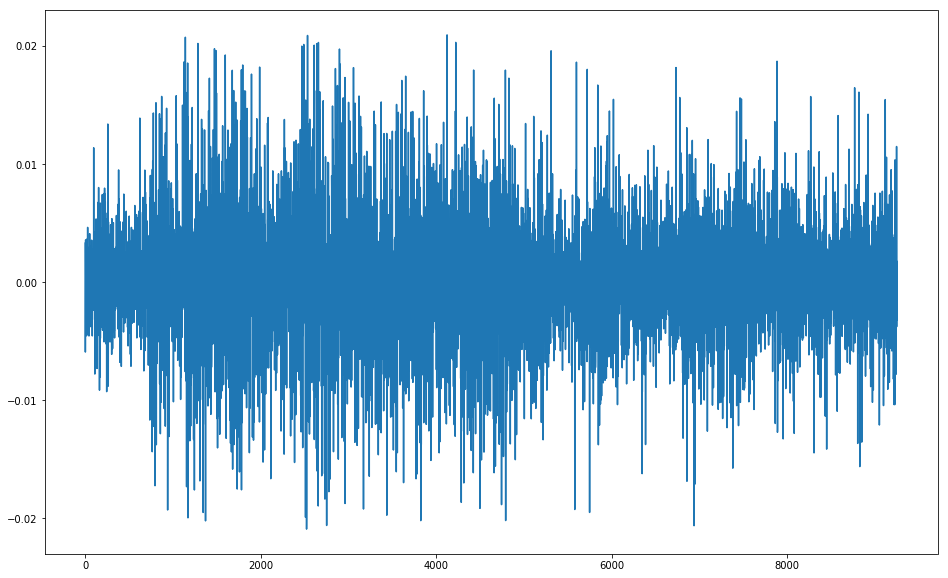

In [31]:
all_signal = load(HEAD_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
vanish_signal = vanish_thre(all_signal, 0.021)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
## kurtosis= 5.240453925443156  skew= -0.015080391934041855
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);

kurtosis= 3.451406595020492  skew= -0.06954141454184519


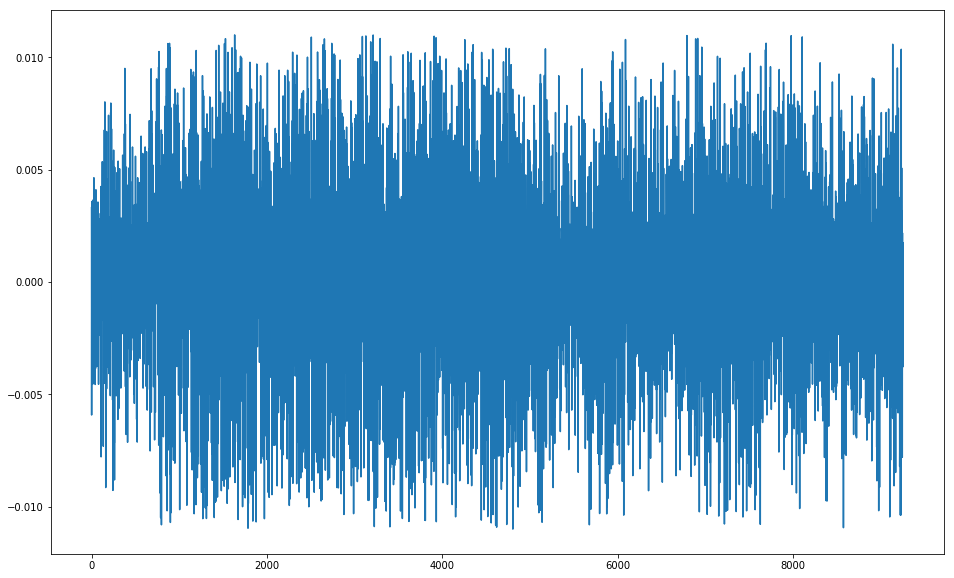

In [32]:
all_signal = load(HEAD_PATH+"/all signal/"+ product_list[0]+ ".ret."+str(period)+".pkl")
vanish_signal = vanish_thre(all_signal, 0.011)
print("kurtosis=", kurtosis(vanish_signal, fisher=False), " skew=", skew(vanish_signal))
plt.figure(1, figsize=(16, 10))
plt.plot(vanish_signal);
## kurtosis= 3.451406595020492  skew= -0.06954141454184519

- it seems 0.01 fits our previous standard for predictive signals
- but now we works for response so there may be some differences


- let's create signals with vanish as well
- our function can support only one parameter so we create twice

In [34]:
class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
    
y2 = foctor_ret_period_002()



In [35]:
for product in product_list:
    create_signal_path(y2, product, HEAD_PATH)

d:/intern/tmp pkl/rb/ret.1024.002
d:/intern/tmp pkl/rb/ret.2048.002
d:/intern/tmp pkl/rb/ret.4096.002
d:/intern/tmp pkl/hc/ret.1024.002
d:/intern/tmp pkl/hc/ret.2048.002
d:/intern/tmp pkl/hc/ret.4096.002
d:/intern/tmp pkl/i/ret.1024.002
d:/intern/tmp pkl/i/ret.2048.002
d:/intern/tmp pkl/i/ret.4096.002
d:/intern/tmp pkl/j/ret.1024.002
d:/intern/tmp pkl/j/ret.2048.002
d:/intern/tmp pkl/j/ret.4096.002
d:/intern/tmp pkl/jm/ret.1024.002
d:/intern/tmp pkl/jm/ret.2048.002
d:/intern/tmp pkl/jm/ret.4096.002


In [37]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y2, product=product, HEAD_PATH=HEAD_PATH)
;
## Wall time: 14min 3s

Wall time: 14min 3s


In [38]:
class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
    
y3 = foctor_ret_period_001()


In [39]:
for product in product_list:
    create_signal_path(y3, product, HEAD_PATH)

d:/intern/tmp pkl/rb/ret.1024.001
d:/intern/tmp pkl/rb/ret.2048.001
d:/intern/tmp pkl/rb/ret.4096.001
d:/intern/tmp pkl/hc/ret.1024.001
d:/intern/tmp pkl/hc/ret.2048.001
d:/intern/tmp pkl/hc/ret.4096.001
d:/intern/tmp pkl/i/ret.1024.001
d:/intern/tmp pkl/i/ret.2048.001
d:/intern/tmp pkl/i/ret.4096.001
d:/intern/tmp pkl/j/ret.1024.001
d:/intern/tmp pkl/j/ret.2048.001
d:/intern/tmp pkl/j/ret.4096.001
d:/intern/tmp pkl/jm/ret.1024.001
d:/intern/tmp pkl/jm/ret.2048.001
d:/intern/tmp pkl/jm/ret.4096.001


In [40]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=y3, product=product, HEAD_PATH=HEAD_PATH)
;
## Wall time: 3min 34s

Wall time: 3min 34s


- now we have 3 response values: future return, future return cut off at 0.02, future return cut of at 0.01


- let's see how they perform with predictive signals


- at first we need to make sum changes 
- we can check the result

In [41]:
sum(train_sample)
## 510

510

In [42]:
sum(test_sample)
## 405

405

- at first we fit a linear regression model without any regularization
- we need to know the length of each day

In [43]:
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [46]:
os.makedirs(HEAD_PATH+"/daily num", exist_ok=True)

In [47]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"/daily num/"+product+".pkl")

Wall time: 1min 49s


- we don't need to do it every time

In [48]:
daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")

- we get the number of independent training samples

In [50]:
n_train = sum(daily_num[train_sample])
n_train
## 2999.0

2999.0

- we can see there there are not many samples
- but they are independent signals because we choose one sample out of every period samples
- for every tick, we predict the price return of next 4096 ticks
- so only 1/4096 of them are independent

- number of signals

In [51]:
n_signal = len(signal_list)
n_signal
## 45

45

In [11]:
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample])
    n_days = sum(sample)
    n_signal = len(signal_list)
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        chosen = (np.arange(sum(data["good"]))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            S = S[data["good"]]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

- Now we get the train and test samples

In [53]:
os.makedirs(HEAD_PATH+"/train test mat/", exist_ok=True)

In [60]:
%%time
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    train_mat = get_sample_signal(all_dates, train_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002"]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"/train test mat/"+product, exist_ok=True)
    save(train_mat, HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    
## Wall time: 1h 28min 44s

Wall time: 1h 28min 44s


In [61]:
train_mat.shape
# (2022, 29)

(2999, 48)

In [44]:
import  sklearn.preprocessing

In [17]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
ori_mat.columns

Index(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
       'range.pos.4096', 'price.osci.4096', 'ma.dif.10.4096', 'kdj.k.4096',
       'kdj.j.4096', 'trade.imb.range.4096', 'total.trade.imb.range.4096',
       'nr.range.4096', 'dbook.range.4096', 'range.pos.range.4096',
       'price.osci.range.4096', 'ma.dif.10.range.4096', 'kdj.k.range.4096',
       'kdj.j.range.4096', 'trade.imb.std.4096', 'total.trade.imb.std.4096',
       'nr.std.4096', 'dbook.std.4096', 'range.pos.std.4096',
       'price.osci.std.4096', 'ma.dif.10.std.4096', 'kdj.k.std.4096',
       'kdj.j.std.4096', 'trade.imb.volume.open.ratio.4096',
       'total.trade.imb.volume.open.ratio.4096', 'nr.volume.open.ratio.4096',
       'dbook.volume.open.ratio.4096', 'range.pos.volume.open.ratio.4096',
       'price.osci.volume.open.ratio.4096', 'ma.dif.10.volume.open.ratio.4096',
       'kdj.k.volume.open.ratio.4096', 'kdj.j.volume.open.ratio.4096',
       'trade.imb.trend.index.4096', 'total.trade.imb.tre

- we add the y signal

- we can check the names

In [114]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=ori_mat.columns)
print(product_list[0], train_mat.shape)
for product in product_list[1:]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=ori_mat.columns)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

rb (5266, 48)
hc (3894, 48)
i (4658, 48)
j (3118, 48)
jm (2999, 48)


In [21]:
train_mat.shape

(19935, 48)

- at first we can fit a linear regression to calcualte t-statistics 

In [115]:
import statsmodels.formula.api as smf

In [116]:
formula = "train_mat['ret."+str(period)+"'] ~ train_mat['nr."+str(period)+"'] + 0"
formula
## "train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

"train_mat['ret.4096'] ~ train_mat['nr.4096'] + 0"

In [117]:
fit_one_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_one_lm.summary())
#  OLS Regression Results                             
# =================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared:                       0.001
# Model:                               OLS   Adj. R-squared:                  0.000
# Method:                    Least Squares   F-statistic:                     10.23
# Date:                   Wed, 16 Oct 2019   Prob (F-statistic):            0.00139
# Time:                           22:51:20   Log-Likelihood:                -28292.
# No. Observations:                  19935   AIC:                         5.659e+04
# Df Residuals:                      19934   BIC:                         5.659e+04
# Df Model:                              1                                         
# Covariance Type:               nonrobust                                         
# ========================================================================================
#                            coef    std err          t      P>|t|      [0.025      0.975]
# ----------------------------------------------------------------------------------------
# train_mat['nr.4096']     0.0226      0.007      3.198      0.001       0.009       0.036
# ==============================================================================
# Omnibus:                     2297.616   Durbin-Watson:                   1.987
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20831.843
# Skew:                          -0.184   Prob(JB):                         0.00
# Kurtosis:                       7.994   Cond. No.                         1.00
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                              OLS Regression Results                             
Dep. Variable:     train_mat['ret.4096']   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     10.23
Date:                   Sat, 19 Oct 2019   Prob (F-statistic):            0.00139
Time:                           23:43:31   Log-Likelihood:                -28292.
No. Observations:                  19935   AIC:                         5.659e+04
Df Residuals:                      19934   BIC:                         5.659e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
tr

In [118]:
def get_t_value(train_mat, signal, response):
    beta = np.sum(train_mat[signal]*train_mat[response])/sum(train_mat[signal]**2)
    sigma = np.sqrt(np.sum((train_mat[signal]*beta-train_mat[response])**2) / (len(train_mat)-1))
    v = np.sqrt(np.sum(train_mat[signal]**2))
    return beta/sigma*v

- we can see our function is correct
- now let's use this function to calcualte all t-stat of each variable

In [119]:
signal_list = np.array(signal_list)
t_stat = list(map(lambda x: get_t_value(train_mat=train_mat, signal=x, response="ret."+str(period)), signal_list))
t_stat
# [-3.611495615006903,
#  3.164739927259585,
#  3.198002726076485,
#  -4.822738801264186,
#  2.7575911663032158,
#  4.657938860344221,
#  1.6529352721680235,
#  3.7585608508863406,
#  2.5074246080482956,
#  -3.0491361697004815,
#  1.4115442629488593,
#  1.4128242337644012,
#  -6.134873595235046,
#  -0.6503622948625044,
#  1.7969532400605526,
#  0.045390959147707126,
#  2.214464450973309,
#  0.7023027572825669,
#  -3.222933690379256,
#  1.1320368242914174,
#  0.9822910188333999,
#  -6.149680367706145,
#  -0.7791708280320117,
#  1.3196031064308733,
#  -0.7298487123690929,
#  1.8927752506924223,
#  0.5443447735464335,
#  -2.9830571935153745,
#  1.9899335412719745,
#  1.8398320165421655,
#  -5.666588495815191,
#  0.1356807292003784,
#  2.246659069225599,
#  -0.6998478078878412,
#  2.3499101468787575,
#  1.0609133761727592,
#  -2.6463935988505507,
#  3.5626443903163967,
#  3.532083281222354,
#  -5.155653412524966,
#  3.343287918282742,
#  4.530848811762212,
#  1.8666390776006276,
#  4.536664902288269,
#  3.896152044619528]

[-3.611495615006903,
 3.164739927259585,
 3.198002726076485,
 -4.822738801264186,
 2.7575911663032158,
 4.657938860344221,
 1.6529352721680235,
 3.7585608508863406,
 2.5074246080482956,
 -3.0491361697004815,
 1.4115442629488593,
 1.4128242337644012,
 -6.134873595235046,
 -0.6503622948625044,
 1.7969532400605526,
 0.045390959147707126,
 2.214464450973309,
 0.7023027572825669,
 -3.222933690379256,
 1.1320368242914174,
 0.9822910188333999,
 -6.149680367706145,
 -0.7791708280320117,
 1.3196031064308733,
 -0.7298487123690929,
 1.8927752506924223,
 0.5443447735464335,
 -2.9830571935153745,
 1.9899335412719745,
 1.8398320165421655,
 -5.666588495815191,
 0.1356807292003784,
 2.246659069225599,
 -0.6998478078878412,
 2.3499101468787575,
 1.0609133761727592,
 -2.6463935988505507,
 3.5626443903163967,
 3.532083281222354,
 -5.155653412524966,
 3.343287918282742,
 4.530848811762212,
 1.8666390776006276,
 4.536664902288269,
 3.896152044619528]

- if we use t.stat value of 3 to filter out good signals, we have

In [120]:
signal_list[np.where(np.abs(t_stat)>3)]
# array(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
#        'price.osci.4096', 'kdj.k.4096', 'trade.imb.range.4096',
#        'dbook.range.4096', 'trade.imb.std.4096', 'dbook.std.4096',
#        'dbook.volume.open.ratio.4096', 'total.trade.imb.trend.index.4096',
#        'nr.trend.index.4096', 'dbook.trend.index.4096',
#        'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
#        'kdj.k.trend.index.4096', 'kdj.j.trend.index.4096'], dtype='<U38')

array(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
       'price.osci.4096', 'kdj.k.4096', 'trade.imb.range.4096',
       'dbook.range.4096', 'trade.imb.std.4096', 'dbook.std.4096',
       'dbook.volume.open.ratio.4096', 'total.trade.imb.trend.index.4096',
       'nr.trend.index.4096', 'dbook.trend.index.4096',
       'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
       'kdj.k.trend.index.4096', 'kdj.j.trend.index.4096'], dtype='<U38')

In [136]:
good_index = signal_list[np.abs(t_stat)>3]
good_index
# array(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
#        'price.osci.4096', 'kdj.k.4096', 'trade.imb.range.4096',
#        'dbook.range.4096', 'trade.imb.std.4096', 'dbook.std.4096',
#        'dbook.volume.open.ratio.4096', 'total.trade.imb.trend.index.4096',
#        'nr.trend.index.4096', 'dbook.trend.index.4096',
#        'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
#        'kdj.k.trend.index.4096', 'kdj.j.trend.index.4096'], dtype='<U38')

array(['trade.imb.4096', 'total.trade.imb.4096', 'nr.4096', 'dbook.4096',
       'price.osci.4096', 'kdj.k.4096', 'trade.imb.range.4096',
       'dbook.range.4096', 'trade.imb.std.4096', 'dbook.std.4096',
       'dbook.volume.open.ratio.4096', 'total.trade.imb.trend.index.4096',
       'nr.trend.index.4096', 'dbook.trend.index.4096',
       'range.pos.trend.index.4096', 'price.osci.trend.index.4096',
       'kdj.k.trend.index.4096', 'kdj.j.trend.index.4096'], dtype='<U38')

- but we know a single signal works well doesn't mean it works well when combined with other signals
- signals have correlation, if 10 highly correlated signals together would not make prediction better

In [137]:
train_mat[good_index].corr()

#  	dbook.range.4096 	kdj.k.trend.index.4096 	kdj.j.abs.nr.4096
# dbook.range.4096 	1.000000 	0.151582 	0.178621
# kdj.k.trend.index.4096 	0.151582 	1.000000 	0.805130
# kdj.j.abs.nr.4096 	0.178621 	0.805130 	1.000000

,trade.imb.4096,total.trade.imb.4096,nr.4096,dbook.4096,price.osci.4096,kdj.k.4096,trade.imb.range.4096,dbook.range.4096,trade.imb.std.4096,dbook.std.4096,dbook.volume.open.ratio.4096,total.trade.imb.trend.index.4096,nr.trend.index.4096,dbook.trend.index.4096,range.pos.trend.index.4096,price.osci.trend.index.4096,kdj.k.trend.index.4096,kdj.j.trend.index.4096
trade.imb.4096,1.000000,0.166648,-0.036883,0.766871,-0.116310,0.005390,0.794253,0.617244,0.741980,0.571292,0.650103,0.142710,0.011471,0.645302,-0.060528,-0.044029,0.027138,-0.027565
total.trade.imb.4096,0.166648,1.000000,0.738826,-0.127800,0.702923,0.656518,0.135198,-0.134324,0.127383,-0.136751,-0.128027,0.903278,0.708499,-0.138345,0.729047,0.667015,0.668077,0.677334
nr.4096,-0.036883,0.738826,1.000000,-0.122128,0.747859,0.693019,-0.014833,-0.132412,-0.026237,-0.123060,-0.156052,0.760568,0.888472,-0.146608,0.751264,0.717780,0.734560,0.715860
dbook.4096,0.766871,-0.127800,-0.122128,1.000000,-0.219614,-0.180442,0.609769,0.823079,0.558456,0.778186,0.842478,-0.109412,-0.110418,0.851233,-0.216497,-0.162410,-0.153795,-0.198090
price.osci.4096,-0.116310,0.702923,0.747859,-0.219614,1.000000,0.681526,-0.040360,-0.190198,-0.036901,-0.185814,-0.201135,0.647968,0.645948,-0.198184,0.724936,0.856754,0.646559,0.663807
kdj.k.4096,0.005390,0.656518,0.693019,-0.180442,0.681526,1.000000,-0.001237,-0.204473,-0.005444,-0.209848,-0.190846,0.690796,0.707149,-0.195081,0.782888,0.690291,0.923447,0.866369
trade.imb.range.4096,0.794253,0.135198,-0.014833,0.609769,-0.040360,-0.001237,1.000000,0.680116,0.973039,0.640744,0.575076,0.129139,-0.013439,0.557730,-0.056432,-0.013610,0.012450,-0.027923
dbook.range.4096,0.617244,-0.134324,-0.132412,0.823079,-0.190198,-0.204473,0.680116,1.000000,0.635230,0.975781,0.805588,-0.132519,-0.111680,0.795098,-0.230802,-0.167070,-0.193119,-0.223957
trade.imb.std.4096,0.741980,0.127383,-0.026237,0.558456,-0.036901,-0.005444,0.973039,0.635230,1.000000,0.619195,0.534200,0.124039,-0.032244,0.521927,-0.051996,-0.017351,0.006726,-0.025966
dbook.std.4096,0.571292,-0.136751,-0.123060,0.778186,-0.185814,-0.209848,0.640744,0.975781,0.619195,1.000000,0.778044,-0.136205,-0.097074,0.775656,-0.232135,-0.166839,-0.199070,-0.226662


In [138]:
corr = train_mat[good_index].corr()

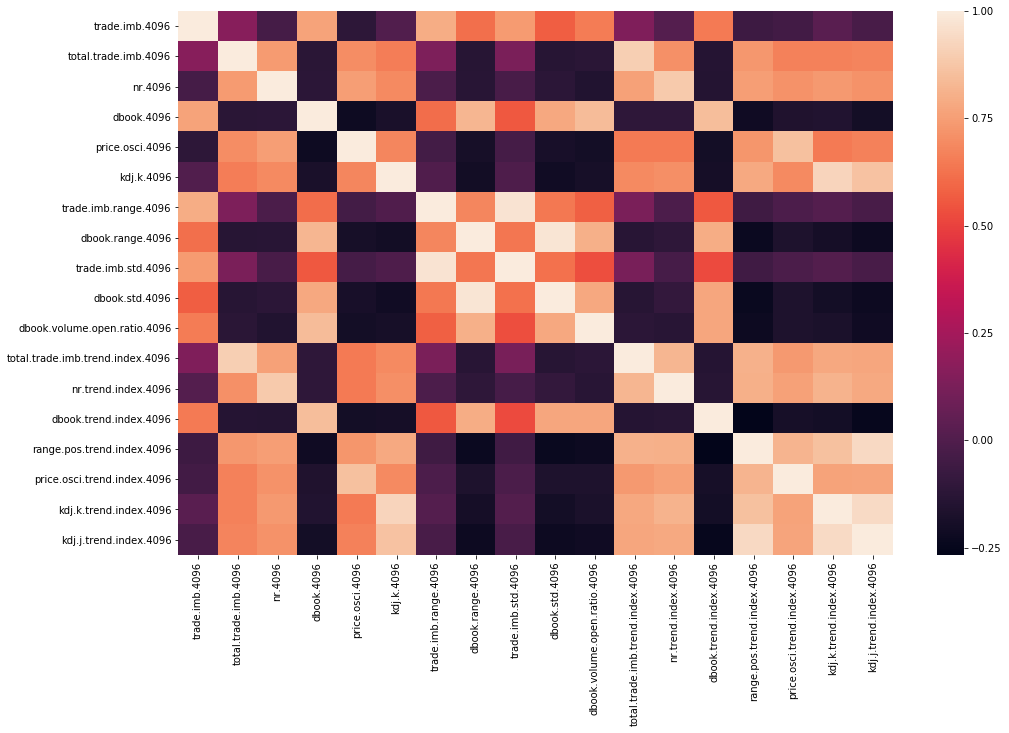

In [139]:
import seaborn as sns
plt.figure(figsize=(16,10)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

- we can see that some of them has very high correlation

- we can add each signal one by one to a model and check how the performance envolves

In [132]:
np.argmax(np.abs(t_stat))
## [1] 21

21

In [133]:
signal_list[np.argmax(np.abs(t_stat))]
## 'dbook.std.4096'

'dbook.std.4096'

- the first signal is the signal dbook.std.4096


- to select the second signal, we can use forward selction

In [23]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    chosen_signals = []
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} - 1".format("data['"+response+"']",
                                           ' + '.join(selected + ["data['"+candidate+"']"]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append("data['"+best_candidate+"']")
            current_score = best_new_score
            chosen_signals.append(best_candidate)
    formula = "{} ~ {} - 1".format("data['"+response+"']",
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return OrderedDict([("model", model), ("chosen.signals", chosen_signals)])

In [135]:
result = forward_selected(train_mat[train_mat.columns[:-2]], "ret."+str(period))

In [140]:
save(result, HEAD_PATH+"/all_forwatd_select.pkl")

In [141]:
result = load(HEAD_PATH+"/all_forwatd_select.pkl");

not in depth 2
not in depth 3
not in depth 1


In [30]:
result["model"].model.formula
# "data['ret.4096'] ~ data['dbook.std.4096'] + data['price.osci.4096'] + data['range.pos.range.4096'] + data['kdj.k.trend.index.4096'] + data['ma.dif.10.range.4096'] + data['ma.dif.10.std.4096'] + data['ma.dif.10.volume.open.ratio.4096'] + data['range.pos.trend.index.4096'] + data['kdj.k.range.4096'] + data['kdj.k.4096'] + data['range.pos.4096'] + data['kdj.j.4096'] + data['kdj.j.range.4096'] + data['kdj.j.trend.index.4096'] + data['nr.std.4096'] + data['nr.4096'] + data['dbook.4096'] + data['dbook.volume.open.ratio.4096'] + data['nr.volume.open.ratio.4096'] - 1"

"data['ret.4096'] ~ data['dbook.std.4096'] + data['price.osci.4096'] + data['range.pos.range.4096'] + data['kdj.k.trend.index.4096'] + data['ma.dif.10.range.4096'] + data['ma.dif.10.std.4096'] + data['ma.dif.10.volume.open.ratio.4096'] + data['range.pos.trend.index.4096'] + data['kdj.k.range.4096'] + data['kdj.k.4096'] + data['range.pos.4096'] + data['kdj.j.4096'] + data['kdj.j.range.4096'] + data['kdj.j.trend.index.4096'] + data['nr.std.4096'] + data['nr.4096'] + data['dbook.4096'] + data['dbook.volume.open.ratio.4096'] + data['nr.volume.open.ratio.4096'] - 1"

In [142]:
result["chosen.signals"]
# ['dbook.std.4096',
#  'price.osci.4096',
#  'range.pos.range.4096',
#  'kdj.k.trend.index.4096',
#  'ma.dif.10.range.4096',
#  'ma.dif.10.std.4096',
#  'ma.dif.10.volume.open.ratio.4096',
#  'range.pos.trend.index.4096',
#  'kdj.k.range.4096',
#  'kdj.k.4096',
#  'range.pos.4096',
#  'kdj.j.4096',
#  'kdj.j.range.4096',
#  'kdj.j.trend.index.4096',
#  'nr.std.4096',
#  'nr.4096',
#  'dbook.4096',
#  'dbook.volume.open.ratio.4096',
#  'nr.volume.open.ratio.4096']

['dbook.std.4096',
 'price.osci.4096',
 'range.pos.range.4096',
 'kdj.k.trend.index.4096',
 'ma.dif.10.range.4096',
 'ma.dif.10.std.4096',
 'ma.dif.10.volume.open.ratio.4096',
 'range.pos.trend.index.4096',
 'kdj.k.range.4096',
 'kdj.k.4096',
 'range.pos.4096',
 'kdj.j.4096',
 'kdj.j.range.4096',
 'kdj.j.trend.index.4096',
 'nr.std.4096',
 'nr.4096',
 'dbook.4096',
 'dbook.volume.open.ratio.4096',
 'nr.volume.open.ratio.4096']

- now we can check each model to see how the pnl evolves


- we can also get the test signals


- we can get the test samples first

In [31]:
%%time
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    test_mat = get_sample_signal(all_dates, test_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002"]), 
                                  period, daily_num)
    os.makedirs(HEAD_PATH+"/train test mat/"+product, exist_ok=True)
    save(test_mat, HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    
## Wall time: 1h 17min 36s


Wall time: 1h 17min 36s


In [27]:
test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")

- now let's fit the first model

In [74]:
first_signal = "dbook.std."+str(period)
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ train_mat['"+first_signal+"']+0"
formula

"train_mat['ret.4096'] ~ train_mat['dbook.std.4096']+0"

In [66]:
fit1_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit1_lm.summary())
#       OLS Regression Results                             
# =================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared:                       0.002
# Model:                               OLS   Adj. R-squared:                  0.002
# Method:                    Least Squares   F-statistic:                     37.82
# Date:                   Thu, 17 Oct 2019   Prob (F-statistic):           7.91e-10
# Time:                           14:52:12   Log-Likelihood:                -28279.
# No. Observations:                  19935   AIC:                         5.656e+04
# Df Residuals:                      19934   BIC:                         5.657e+04
# Df Model:                              1                                         
# Covariance Type:               nonrobust                                         
# ===============================================================================================
#                                   coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------
# train_mat['dbook.std.4096']    -0.0426      0.007     -6.150      0.000      -0.056      -0.029
# ==============================================================================
# Omnibus:                     2281.536   Durbin-Watson:                   1.973
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20642.905
# Skew:                          -0.176   Prob(JB):                         0.00
# Kurtosis:                       7.973   Cond. No.                         1.00
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                              OLS Regression Results                             
Dep. Variable:     train_mat['ret.4096']   R-squared:                       0.002
Model:                               OLS   Adj. R-squared:                  0.002
Method:                    Least Squares   F-statistic:                     37.82
Date:                   Thu, 17 Oct 2019   Prob (F-statistic):           7.91e-10
Time:                           18:05:50   Log-Likelihood:                -28279.
No. Observations:                  19935   AIC:                         5.656e+04
Df Residuals:                      19934   BIC:                         5.657e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

- we can see that the single R-square is already 0.0005814431935065034


- now we want to get the prediction value

In [38]:
strat = "one."+str(period)

- create a directory for the first strate

In [88]:
for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

- we get the coefficiton of fit1.lm

In [93]:
fit_coef = fit1_lm.params.values
fit_coef
# array([-0.04256225])



array([-0.04256225])

- but since we have standardize the training samples before regrssion
- we must revert the result to original scale

In [85]:
train_std = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std[product] = np.std(cur_mat)

In [86]:
coef = fit_coef*train_std[product_list[0]][y_signal]/train_std[product_list[0]][first_signal]
coef
## array([-0.00080093])

array([-0.00080093])

In [89]:
%%time
for product in product_list:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][first_signal]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=[first_signal], coef=coef, strat=strat, HEAD_PATH=HEAD_PATH)
;

## Wall time: 7min 1s

Wall time: 7min 1s


In [23]:
%%time
for product in product_list:
    par_get_all_signal("one.4096", all_dates, product, 4096, HEAD_PATH="d:/intern")
##Wall time: 13min 28s

Wall time: 13min 28s


In [25]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("one", all_dates, product, 2, 20, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 5min 29s


reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 33s


In [33]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"one.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# rb train sharpe  1.9127232685752373 test sharpe  0.9584319255780096
# hc train sharpe  0.917633153232838 test sharpe  0.5104135402657566
# i train sharpe  0.45505617659901054 test sharpe  -0.7856742013183898
# j train sharpe  1.0118309783770423 test sharpe  0.01757407150728489
# jm train sharpe  1.2508863961989867 test sharpe  0.9674501096241781


rb train sharpe  1.9127232685752373 test sharpe  0.9584319255780096
hc train sharpe  0.917633153232838 test sharpe  0.5104135402657566
i train sharpe  0.45505617659901054 test sharpe  -0.7856742013183898
j train sharpe  1.0118309783770423 test sharpe  0.01757407150728489
jm train sharpe  1.2508863961989867 test sharpe  0.9674501096241781


In [134]:
len(result["chosen.signals"])

15

- then we work similar to previous common signals

- now we try to add a few new signal

In [63]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
n_signal = 10
for signal in result["chosen.signals"][:n_signal]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

#"train_mat['ret.4096'] ~ +train_mat['dbook.std.4096']+train_mat['price.osci.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.std.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['range.pos.trend.index.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.k.4096']+0"

"train_mat['ret.4096'] ~ +train_mat['dbook.std.4096']+train_mat['price.osci.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.std.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['range.pos.trend.index.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.k.4096']+0"

In [65]:
fit_half_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_half_lm.summary())

#       OLS Regression Results                             
# =================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared:                       0.007
# Model:                               OLS   Adj. R-squared:                  0.006
# Method:                    Least Squares   F-statistic:                     13.26
# Date:                   Fri, 18 Oct 2019   Prob (F-statistic):           1.65e-23
# Time:                           16:52:45   Log-Likelihood:                -28231.
# No. Observations:                  19935   AIC:                         5.648e+04
# Df Residuals:                      19925   BIC:                         5.656e+04
# Df Model:                             10                                         
# Covariance Type:               nonrobust                                         
# =================================================================================================================
#                                                     coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------------
# train_mat['dbook.std.4096']                      -0.0448      0.007     -6.149      0.000      -0.059      -0.031
# train_mat['price.osci.4096']                      0.0440      0.011      3.866      0.000       0.022       0.066
# train_mat['range.pos.range.4096']                -0.1203      0.020     -5.962      0.000      -0.160      -0.081
# train_mat['kdj.k.trend.index.4096']               0.0284      0.026      1.072      0.284      -0.024       0.080
# train_mat['ma.dif.10.range.4096']                 0.1107      0.031      3.577      0.000       0.050       0.171
# train_mat['ma.dif.10.std.4096']                  -0.0820      0.028     -2.964      0.003      -0.136      -0.028
# train_mat['ma.dif.10.volume.open.ratio.4096']    -0.0376      0.014     -2.769      0.006      -0.064      -0.011
# train_mat['range.pos.trend.index.4096']           0.0514      0.022      2.305      0.021       0.008       0.095
# train_mat['kdj.k.range.4096']                     0.0526      0.025      2.116      0.034       0.004       0.101
# train_mat['kdj.k.4096']                          -0.0375      0.023     -1.640      0.101      -0.082       0.007
# ==============================================================================
# Omnibus:                     2240.756   Durbin-Watson:                   1.999
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19972.685
# Skew:                          -0.164   Prob(JB):                         0.00
# Kurtosis:                       7.893   Cond. No.                         14.5
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

                              OLS Regression Results                             
Dep. Variable:     train_mat['ret.4096']   R-squared:                       0.007
Model:                               OLS   Adj. R-squared:                  0.006
Method:                    Least Squares   F-statistic:                     13.26
Date:                   Fri, 18 Oct 2019   Prob (F-statistic):           1.65e-23
Time:                           16:52:45   Log-Likelihood:                -28231.
No. Observations:                  19935   AIC:                         5.648e+04
Df Residuals:                      19925   BIC:                         5.656e+04
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [68]:
strat = "half."+str(period)
os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_half_lm.params.values
fit_coef
#array([-0.04480095,  0.04400857, -0.12030828,  0.02839326,  0.11074066,
#       -0.08197656, -0.03762745,  0.05138238,  0.05260907, -0.03749734])

array([-0.04480095,  0.04400857, -0.12030828,  0.02839326,  0.11074066,
       -0.08197656, -0.03762745,  0.05138238,  0.05260907, -0.03749734])

In [38]:
train_std_mat = dict([])
for product in product_list:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [91]:
for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [92]:
%%time
for product in product_list:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:10]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:10], coef=coef, strat=strat, HEAD_PATH=HEAD_PATH)
;
#Wall time: 25min 16s


Wall time: 25min 16s


In [94]:
%%time
for product in product_list:
    par_get_all_signal("half.4096", all_dates, product, 4096, HEAD_PATH="d:/intern")
##Wall time: 13min 28s

Wall time: 13min 25s


In [95]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("half", all_dates, product, 2, 20, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 11s


In [152]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"half.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# rb train sharpe  1.5087587260185147 test sharpe  0.5435115989362888
# hc train sharpe  1.3163668002045286 test sharpe  0.43393342334925783
# i train sharpe  1.149040743970226 test sharpe  -0.5492190956631218
# j train sharpe  1.0612819393874031 test sharpe  1.083466412606586
# jm train sharpe  1.3330174025222248 test sharpe  1.2884672527364454



rb train sharpe  1.5087587260185147 test sharpe  0.5435115989362888
hc train sharpe  1.3163668002045286 test sharpe  0.43393342334925783
i train sharpe  1.149040743970226 test sharpe  -0.5492190956631218
j train sharpe  1.0612819393874031 test sharpe  1.083466412606586
jm train sharpe  1.3330174025222248 test sharpe  1.2884672527364454


In [34]:
y_signal = "ret."+str(period)
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

#"train_mat['ret.4096'] ~ +train_mat['dbook.std.4096']+train_mat['price.osci.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.std.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['range.pos.trend.index.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.k.4096']+train_mat['range.pos.4096']+train_mat['kdj.j.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.trend.index.4096']+train_mat['nr.std.4096']+train_mat['nr.4096']+train_mat['dbook.4096']+train_mat['dbook.volume.open.ratio.4096']+train_mat['nr.volume.open.ratio.4096']+0"

"train_mat['ret.4096'] ~ +train_mat['dbook.std.4096']+train_mat['price.osci.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.std.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['range.pos.trend.index.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.k.4096']+train_mat['range.pos.4096']+train_mat['kdj.j.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.trend.index.4096']+train_mat['nr.std.4096']+train_mat['nr.4096']+train_mat['dbook.4096']+train_mat['dbook.volume.open.ratio.4096']+train_mat['nr.volume.open.ratio.4096']+0"

- now we look at the full model

In [35]:
fit_full_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
print(fit_full_lm.summary())
#                               OLS Regression Results                             
# =================================================================================
# Dep. Variable:     train_mat['ret.4096']   R-squared:                       0.008
# Model:                               OLS   Adj. R-squared:                  0.008
# Method:                    Least Squares   F-statistic:                     8.982
# Date:                   Fri, 18 Oct 2019   Prob (F-statistic):           2.83e-26
# Time:                           22:59:34   Log-Likelihood:                -28212.
# No. Observations:                  19935   AIC:                         5.646e+04
# Df Residuals:                      19916   BIC:                         5.661e+04
# Df Model:                             19                                         
# Covariance Type:               nonrobust                                         
# =================================================================================================================
#                                                     coef    std err          t      P>|t|      [0.025      0.975]
# -----------------------------------------------------------------------------------------------------------------
# train_mat['dbook.std.4096']                      -0.0488      0.013     -3.874      0.000      -0.073      -0.024
# train_mat['price.osci.4096']                      0.0278      0.014      1.964      0.050    4.98e-05       0.055
# train_mat['range.pos.range.4096']                -0.2295      0.036     -6.299      0.000      -0.301      -0.158
# train_mat['kdj.k.trend.index.4096']               0.0172      0.043      0.397      0.691      -0.068       0.102
# train_mat['ma.dif.10.range.4096']                 0.1275      0.032      4.040      0.000       0.066       0.189
# train_mat['ma.dif.10.std.4096']                  -0.0993      0.032     -3.108      0.002      -0.162      -0.037
# train_mat['ma.dif.10.volume.open.ratio.4096']    -0.0612      0.021     -2.891      0.004      -0.103      -0.020
# train_mat['range.pos.trend.index.4096']          -0.0608      0.041     -1.499      0.134      -0.140       0.019
# train_mat['kdj.k.range.4096']                     0.0007      0.039      0.019      0.985      -0.076       0.078
# train_mat['kdj.k.4096']                           0.0084      0.039      0.215      0.829      -0.068       0.085
# train_mat['range.pos.4096']                       0.2236      0.043      5.197      0.000       0.139       0.308
# train_mat['kdj.j.4096']                          -0.2196      0.052     -4.190      0.000      -0.322      -0.117
# train_mat['kdj.j.range.4096']                     0.1380      0.054      2.554      0.011       0.032       0.244
# train_mat['kdj.j.trend.index.4096']               0.1233      0.060      2.073      0.038       0.007       0.240
# train_mat['nr.std.4096']                          0.0273      0.017      1.571      0.116      -0.007       0.061
# train_mat['nr.4096']                             -0.0443      0.018     -2.444      0.015      -0.080      -0.009
# train_mat['dbook.4096']                           0.0354      0.014      2.443      0.015       0.007       0.064
# train_mat['dbook.volume.open.ratio.4096']        -0.0306      0.014     -2.145      0.032      -0.059      -0.003
# train_mat['nr.volume.open.ratio.4096']            0.0286      0.021      1.341      0.180      -0.013       0.070
# ==============================================================================
# Omnibus:                     2199.699   Durbin-Watson:                   2.001
# Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19277.202
# Skew:                          -0.152   Prob(JB):                         0.00
# Kurtosis:                       7.808   Cond. No.                         43.4
# ==============================================================================

# Warnings:
# [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

# ​

                              OLS Regression Results                             
Dep. Variable:     train_mat['ret.4096']   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.008
Method:                    Least Squares   F-statistic:                     8.982
Date:                   Fri, 18 Oct 2019   Prob (F-statistic):           2.83e-26
Time:                           23:27:39   Log-Likelihood:                -28212.
No. Observations:                  19935   AIC:                         5.646e+04
Df Residuals:                      19916   BIC:                         5.661e+04
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [40]:
strat = "full."+str(period)
os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_full_lm.params.values
fit_coef
# array([-0.04878916,  0.02776062, -0.22951796,  0.01722934,  0.12753776,
#        -0.09930048, -0.06124559, -0.06082973,  0.00073911,  0.00839828,
#         0.22356773, -0.21961847,  0.13803354,  0.12332368,  0.02732981,
#        -0.04428479,  0.03536779, -0.03061114,  0.02861395])

array([-0.04878916,  0.02776062, -0.22951796,  0.01722934,  0.12753776,
       -0.09930048, -0.06124559, -0.06082973,  0.00073911,  0.00839828,
        0.22356773, -0.21961847,  0.13803354,  0.12332368,  0.02732981,
       -0.04428479,  0.03536779, -0.03061114,  0.02861395])

In [107]:
for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [41]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"]]
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"], coef=coef, strat="full.4096", HEAD_PATH=HEAD_PATH)
    
# rb
# hc
# i
# j
# jm
# Wall time: 1h 2min 20s

rb
hc
i
j
jm
Wall time: 1h 2min 20s


In [42]:
%%time
for product in product_list:
    par_get_all_signal("full.4096", all_dates, product, 4096, HEAD_PATH="d:/intern")
##Wall time: 13min 28s

Wall time: 13min 40s


In [43]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("full", all_dates, product, 2, 20, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 4min 44s


reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 4min 44s


In [44]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"full.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

# rb train sharpe  1.704618814398022 test sharpe  0.6365400917490537
# hc train sharpe  1.456652408617159 test sharpe  -0.31265191226212263
# i train sharpe  1.1726148281676756 test sharpe  -0.2389617502474381
# j train sharpe  1.418748107108979 test sharpe  0.19663675769340597
# jm train sharpe  1.039996018429806 test sharpe  1.5959995793218809


rb train sharpe  1.704618814398022 test sharpe  0.6365400917490537
hc train sharpe  1.456652408617159 test sharpe  -0.31265191226212263
i train sharpe  1.1726148281676756 test sharpe  -0.2389617502474381
j train sharpe  1.418748107108979 test sharpe  0.19663675769340597
jm train sharpe  1.039996018429806 test sharpe  1.5959995793218809


In [46]:
train_mat.columns[np.append(np.arange(0,26,1),28)]

Index(['nr.4096', 'dbook.4096', 'range.pos.4096', 'ma.dif.10.4096',
       'kdj.k.4096', 'kdj.j.4096', 'nr.std.4096', 'dbook.std.4096',
       'range.pos.std.4096', 'ma.dif.10.std.4096', 'kdj.k.std.4096',
       'kdj.j.std.4096', 'nr.range.4096', 'dbook.range.4096',
       'ma.dif.10.range.4096', 'kdj.k.range.4096', 'kdj.j.range.4096',
       'nr.trend.index.4096', 'range.pos.trend.index.4096',
       'ma.dif.10.trend.index.4096', 'kdj.k.trend.index.4096',
       'kdj.j.trend.index.4096', 'dbook.abs.nr.4096', 'kdj.k.abs.nr.4096',
       'range.pos.abs.nr.4096', 'kdj.j.abs.nr.4096', 'ret.4096.002'],
      dtype='object')

In [45]:
y_signal = "ret."+str(period)+".002"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"][:10]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula

"train_mat['ret.4096.002'] ~ +train_mat['dbook.std.4096']+train_mat['price.osci.4096']+train_mat['range.pos.range.4096']+train_mat['kdj.k.trend.index.4096']+train_mat['ma.dif.10.range.4096']+train_mat['ma.dif.10.std.4096']+train_mat['ma.dif.10.volume.open.ratio.4096']+train_mat['range.pos.trend.index.4096']+train_mat['kdj.k.range.4096']+train_mat['kdj.k.4096']+0"

In [82]:
fit_002_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "half.002."+str(period)
for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_002_lm.params.values
fit_coef
# array([-0.04172749,  0.03307341, -0.0734288 ,  0.0091929 ,  0.04530266,
#        -0.03520079,  0.00279073,  0.02965995,  0.00508659, -0.00308378])


array([-0.03368195, -0.0589743 ,  0.04862577,  0.04658016, -0.01877884,
        0.0756933 , -0.05820322,  0.02459242, -0.05687115])

In [58]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:10]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:10], 
              coef=coef, strat=strat, HEAD_PATH=HEAD_PATH)
;

# rb
# dbook.std.4096                     -0.000668
# price.osci.4096                     0.000329
# range.pos.range.4096               -0.000091
# kdj.k.trend.index.4096              0.000171
# ma.dif.10.range.4096                0.000915
# ma.dif.10.std.4096                 -0.002837
# ma.dif.10.volume.open.ratio.4096    0.008313
# range.pos.trend.index.4096          0.002005
# kdj.k.range.4096                    0.000002
# kdj.k.4096                         -0.000039
# dtype: float64
# hc
# dbook.std.4096                     -0.000962
# price.osci.4096                     0.000388
# range.pos.range.4096               -0.000084
# kdj.k.trend.index.4096              0.000194
# ma.dif.10.range.4096                0.000863
# ma.dif.10.std.4096                 -0.002617
# ma.dif.10.volume.open.ratio.4096    0.011209
# range.pos.trend.index.4096          0.002229
# kdj.k.range.4096                    0.000002
# kdj.k.4096                         -0.000044
# dtype: float64
# i
# dbook.std.4096                     -0.002443
# price.osci.4096                     0.000418
# range.pos.range.4096               -0.000493
# kdj.k.trend.index.4096              0.000205
# ma.dif.10.range.4096                0.003708
# ma.dif.10.std.4096                 -0.010451
# ma.dif.10.volume.open.ratio.4096    0.008791
# range.pos.trend.index.4096          0.002476
# kdj.k.range.4096                    0.000009
# kdj.k.4096                         -0.000046
# dtype: float64
# j
# dbook.std.4096                     -0.001843
# price.osci.4096                     0.000567
# range.pos.range.4096               -0.000141
# kdj.k.trend.index.4096              0.000243
# ma.dif.10.range.4096                0.001039
# ma.dif.10.std.4096                 -0.002831
# ma.dif.10.volume.open.ratio.4096    0.007360
# range.pos.trend.index.4096          0.002793
# kdj.k.range.4096                    0.000003
# kdj.k.4096                         -0.000053
# dtype: float64
# jm
# dbook.std.4096                     -0.002111
# price.osci.4096                     0.000555
# range.pos.range.4096               -0.000201
# kdj.k.trend.index.4096              0.000259
# ma.dif.10.range.4096                0.001427
# ma.dif.10.std.4096                 -0.004185
# ma.dif.10.volume.open.ratio.4096    0.008641
# range.pos.trend.index.4096          0.003048
# kdj.k.range.4096                    0.000004
# kdj.k.4096                         -0.000056
# dtype: float64
# Wall time: 7min 33s


rb
dbook.std.4096                     -0.000668
price.osci.4096                     0.000329
range.pos.range.4096               -0.000091
kdj.k.trend.index.4096              0.000171
ma.dif.10.range.4096                0.000915
ma.dif.10.std.4096                 -0.002837
ma.dif.10.volume.open.ratio.4096    0.008313
range.pos.trend.index.4096          0.002005
kdj.k.range.4096                    0.000002
kdj.k.4096                         -0.000039
dtype: float64
hc
dbook.std.4096                     -0.000962
price.osci.4096                     0.000388
range.pos.range.4096               -0.000084
kdj.k.trend.index.4096              0.000194
ma.dif.10.range.4096                0.000863
ma.dif.10.std.4096                 -0.002617
ma.dif.10.volume.open.ratio.4096    0.011209
range.pos.trend.index.4096          0.002229
kdj.k.range.4096                    0.000002
kdj.k.4096                         -0.000044
dtype: float64
i
dbook.std.4096                     -0.002443
price.osci.4096  

- now we try the ret.4096.002 as response

In [86]:
%%time
for product in product_list:
    par_get_all_signal("half.002.4096", all_dates, product, 4096, HEAD_PATH="d:/intern")
    
## Wall time: 10min 9s

Wall time: 10min 9s


In [87]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("half.002", all_dates, product, 2, 20, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 4min 52s


In [88]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"half.002.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

## hafl.002
# rb train sharpe  1.805163613001169 test sharpe  0.6621112321856355
# hc train sharpe  1.4598213101929218 test sharpe  0.8867239507359027
# i train sharpe  0.9741634182244937 test sharpe  -0.17454451392139766
# j train sharpe  0.9325288372188562 test sharpe  0.946739073723811
# jm train sharpe  1.5053053560092053 test sharpe  1.2463778729387376


## original half
# rb train sharpe  1.5087587260185147 test sharpe  0.5435115989362888
# hc train sharpe  1.3163668002045286 test sharpe  0.43393342334925783
# i train sharpe  1.149040743970226 test sharpe  -0.5492190956631218
# j train sharpe  1.0612819393874031 test sharpe  1.083466412606586
# jm train sharpe  1.3330174025222248 test sharpe  1.2884672527364454


rb train sharpe  1.805163613001169 test sharpe  0.6621112321856355
hc train sharpe  1.4598213101929218 test sharpe  0.8867239507359027
i train sharpe  0.9741634182244937 test sharpe  -0.17454451392139766
j train sharpe  0.9325288372188562 test sharpe  0.946739073723811
jm train sharpe  1.5053053560092053 test sharpe  1.2463778729387376


- now we try to use ret.001

In [145]:
y_signal = "ret."+str(period)+".001"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in result["chosen.signals"][:10]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
fit_001_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
strat = "half.001."+str(period)
for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_001_lm.params.values
fit_coef
# array([-0.03221915,  0.02424631, -0.02997526, -0.01562285, -0.00965228,
#        -0.0001313 , -0.00586716,  0.01798759,  0.03440735, -0.02230567])



array([-0.03221915,  0.02424631, -0.02997526, -0.01562285, -0.00965228,
       -0.0001313 , -0.00586716,  0.01798759,  0.03440735, -0.02230567])

In [146]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][result["chosen.signals"][:10]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=result["chosen.signals"][:10], 
              coef=coef, strat=strat, HEAD_PATH=HEAD_PATH)
;



rb
dbook.std.4096                     -0.000383
price.osci.4096                     0.000179
range.pos.range.4096               -0.000028
kdj.k.trend.index.4096             -0.000216
ma.dif.10.range.4096               -0.000145
ma.dif.10.std.4096                 -0.000008
ma.dif.10.volume.open.ratio.4096   -0.013000
range.pos.trend.index.4096          0.000905
kdj.k.range.4096                    0.000009
kdj.k.4096                         -0.000209
dtype: float64
hc
dbook.std.4096                     -0.000525
price.osci.4096                     0.000201
range.pos.range.4096               -0.000024
kdj.k.trend.index.4096             -0.000233
ma.dif.10.range.4096               -0.000130
ma.dif.10.std.4096                 -0.000007
ma.dif.10.volume.open.ratio.4096   -0.016668
range.pos.trend.index.4096          0.000956
kdj.k.range.4096                    0.000008
kdj.k.4096                         -0.000225
dtype: float64
i
dbook.std.4096                     -0.001244
price.osci.4096  

In [147]:
%%time
for product in product_list:
    par_get_all_signal("half.001.4096", all_dates, product, 4096, HEAD_PATH="d:/intern")


Wall time: 13min 30s


In [148]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("half.001", all_dates, product, 2, 20, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 4min 59s


In [151]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"half.001.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

## half.001.4096
# rb train sharpe  1.9202445602756277 test sharpe  1.5630880186352167
# hc train sharpe  1.0281880639838406 test sharpe  1.195426918559872
# i train sharpe  0.7673063794629459 test sharpe  -0.46049206413075866
# j train sharpe  1.1803814823909604 test sharpe  0.8638922041684458
# jm train sharpe  1.4082211056397258 test sharpe  1.3772306552717015
# Wall time: 72.4 ms

## half.002.4096
# rb train sharpe  1.805163613001169 test sharpe  0.6621112321856355
# hc train sharpe  1.4598213101929218 test sharpe  0.8867239507359027
# i train sharpe  0.9741634182244937 test sharpe  -0.17454451392139766
# j train sharpe  0.9325288372188562 test sharpe  0.946739073723811
# jm train sharpe  1.5053053560092053 test sharpe  1.2463778729387376

## original half
# rb train sharpe  1.5087587260185147 test sharpe  0.5435115989362888
# hc train sharpe  1.3163668002045286 test sharpe  0.43393342334925783
# i train sharpe  1.149040743970226 test sharpe  -0.5492190956631218
# j train sharpe  1.0612819393874031 test sharpe  1.083466412606586
# jm train sharpe  1.3330174025222248 test sharpe  1.2884672527364454



rb train sharpe  1.9202445602756277 test sharpe  1.5630880186352167
hc train sharpe  1.0281880639838406 test sharpe  1.195426918559872
i train sharpe  0.7673063794629459 test sharpe  -0.46049206413075866
j train sharpe  1.1803814823909604 test sharpe  0.8638922041684458
jm train sharpe  1.4082211056397258 test sharpe  1.3772306552717015
Wall time: 72.4 ms


In [73]:

import statsmodels.formula.api as smf
def step_aic(model, exog, endog, **kwargs):
    """
    This select the best exogenous variables with AIC
    Both exog and endog values can be either str or list.
    (Endog list is for the Binomial family.)

    Note: This adopt only "forward" selection

    Args:
        model: model from statsmodels.formula.api
        exog (str or list): exogenous variables
        endog (str or list): endogenous variables
        kwargs: extra keyword argments for model (e.g., data, family)

    Returns:
        model: a model that seems to have the smallest AIC
    """
    for key in kwargs.keys():
        df = kwargs[key]
    df_name = "df"    
    remaining = set(exog)
    
    exog = [df_name+"['"+s+"']" for s in exog]
    endog = [df_name+"['"+s+"']" for s in endog]
    
        
    # exog, endogは強制的にリスト形式に変換しておく
    exog = np.r_[[exog]].flatten()
    endog = np.r_[[endog]].flatten()
    selected = []  # 採用が確定された要因
    chosen_signals = []
    # 定数項のみのAICを計算
    formula_head = ' + '.join(endog) + ' ~ '
    formula = formula_head + '1'
    #aic = model(formula=formula, **kwargs).fit().aic
    aic = model(formula=formula, data=df).fit().aic
    print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

    current_score, best_new_score = np.ones(2) * aic

    # 全要因を採択するか，どの要因を追加してもAICが上がらなければ終了
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:

            # 残っている要因を1つずつ追加したときのAICを計算
            formula_tail = ' + '.join(selected + [df_name+"['"+candidate+"']"])
            formula = formula_head + formula_tail
            #aic = model(formula=formula, **kwargs).fit().aic
            aic = model(formula=formula, data=df).fit().aic
            print('AIC: {}, formula: {}'.format(round(aic, 3), formula))

            scores_with_candidates.append((aic, candidate))

        # 最もAICが小さかった要因をbest_candidateとする
        scores_with_candidates.sort()
        scores_with_candidates.reverse()
        best_new_score, best_candidate = scores_with_candidates.pop()

        # 候補要因追加でAICが下がったならば，それを確定要因として追加する
        
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(df_name+"['"+best_candidate+"']")
            chosen_signals.append(best_candidate)
            current_score = best_new_score

    formula = formula_head + ' + '.join(selected)
    print('The best formula: {}'.format(formula))
    #return model(formula, **kwargs).fit()
    result = OrderedDict([("model", model), ("chosen.signals", chosen_signals)])
    #return model(formula, data=df).fit()
    return result

In [74]:
fwd_model = step_aic(smf.ols, train_mat.columns[:-3], ["ret."+str(period)+".001"], data=train_mat)
# The best formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['ma.dif.10.4096']

AIC: 56577.966, formula: df['ret.4096.001'] ~ 1
AIC: 56570.138, formula: df['ret.4096.001'] ~ df['dbook.std.4096']
AIC: 56579.62, formula: df['ret.4096.001'] ~ df['ma.dif.10.volume.open.ratio.4096']
AIC: 56579.547, formula: df['ret.4096.001'] ~ df['ma.dif.10.std.4096']
AIC: 56579.837, formula: df['ret.4096.001'] ~ df['nr.trend.index.4096']
AIC: 56579.67, formula: df['ret.4096.001'] ~ df['ma.dif.10.trend.index.4096']
AIC: 56572.474, formula: df['ret.4096.001'] ~ df['trade.imb.trend.index.4096']
AIC: 56579.945, formula: df['ret.4096.001'] ~ df['nr.std.4096']
AIC: 56579.945, formula: df['ret.4096.001'] ~ df['kdj.j.range.4096']
AIC: 56579.814, formula: df['ret.4096.001'] ~ df['kdj.k.4096']
AIC: 56579.775, formula: df['ret.4096.001'] ~ df['price.osci.trend.index.4096']
AIC: 56579.64, formula: df['ret.4096.001'] ~ df['kdj.j.trend.index.4096']
AIC: 56579.629, formula: df['ret.4096.001'] ~ df['total.trade.imb.volume.open.ratio.4096']
AIC: 56576.798, formula: df['ret.4096.001'] ~ df['trade.imb.

AIC: 56565.039, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['price.osci.trend.index.4096']
AIC: 56567.831, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['kdj.j.trend.index.4096']
AIC: 56565.722, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['total.trade.imb.volume.open.ratio.4096']
AIC: 56567.872, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['trade.imb.volume.open.ratio.4096']
AIC: 56568.006, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['trade.imb.std.4096']
AIC: 56567.875, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['total.trade.imb.4096']
AIC: 56567.314, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['total.trade.imb.std.4096']
AIC: 56562.85, formula: df['ret.4096.001']

AIC: 56564.26, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['kdj.k.volume.open.ratio.4096']
AIC: 56564.707, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['nr.volume.open.ratio.4096']
AIC: 56563.908, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['ma.dif.10.range.4096']
AIC: 56564.099, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['dbook.volume.open.ratio.4096']
AIC: 56564.329, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['range.pos.4096']
AIC: 56564.409, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['dbook.4096']
AIC: 56564.053, formula: df['ret.4096.001'

AIC: 56564.65, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['price.osci.range.4096']
AIC: 56564.358, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['nr.4096']
AIC: 56563.789, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['trade.imb.range.4096']
AIC: 56563.993, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['dbook.trend.index.4096']
AIC: 56562.933, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['kdj.j.volume.open.ratio.4096']
AIC: 56564.165, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb

AIC: 56562.371, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['range.pos.trend.index.4096']
AIC: 56562.542, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['dbook.range.4096']
AIC: 56562.612, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['price.osci.range.4096']
AIC: 56562.745, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['nr.4096']
AIC: 56562.253, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.tre

AIC: 56559.436, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['range.pos.4096']
AIC: 56561.159, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['dbook.4096']
AIC: 56555.918, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.4096']
AIC: 56560.598, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.k.std.4096']
AIC: 56560.55, formula: df['ret.4096

AIC: 56556.102, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['range.pos.std.4096']
AIC: 56555.037, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['nr.range.4096']
AIC: 56552.393, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['ma.dif.10.4096']
AIC: 56555.325, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volum

AIC: 56553.225, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['price.osci.trend.index.4096']
AIC: 56553.26, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['trade.imb.volume.open.ratio.4096']
AIC: 56552.453, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['trade.imb.std.4096']
AIC

AIC: 56552.196, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['price.osci.std.4096']
AIC: 56553.254, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['price.osci.volume.open.ratio.4096']
AIC: 56550.514, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['ma.dif.10.4096'] + df['ma.dif.

AIC: 56551.197, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['ma.dif.10.4096'] + df['total.trade.imb.trend.index.4096']
AIC: 56551.568, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.4096'] + df['ma.dif.10.4096'] + df['kdj.j.std.4096']
AIC: 56549.849, formula: df['ret.4096.001'] ~ df['dbook.std.4096'] + df['total.trade.imb.range.4096'] + df['nr.trend.index.4096'] + df['price.osci.4096'] + df['range.pos.volume.open.ratio.4096'] + df['kdj.j.range.4096'] + df['kdj.j.trend.index.4096'] + df['total.trade.imb.volume.open.ratio.409

In [75]:
y_signal = "ret."+str(period)+".001"
formula = "train_mat['" + y_signal+"'] ~ "
for signal in fwd_model["chosen.signals"]:
    formula = formula+"+train_mat['"+signal+"']"
formula+="+0"
formula
## "train_mat['ret.4096.001'] ~ +train_mat['dbook.std.4096']+train_mat['total.trade.imb.range.4096']+train_mat['nr.trend.index.4096']+train_mat['price.osci.4096']+train_mat['range.pos.volume.open.ratio.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.trend.index.4096']+train_mat['total.trade.imb.volume.open.ratio.4096']+train_mat['ma.dif.10.4096']+0"



"train_mat['ret.4096.001'] ~ +train_mat['dbook.std.4096']+train_mat['total.trade.imb.range.4096']+train_mat['nr.trend.index.4096']+train_mat['price.osci.4096']+train_mat['range.pos.volume.open.ratio.4096']+train_mat['kdj.j.range.4096']+train_mat['kdj.j.trend.index.4096']+train_mat['total.trade.imb.volume.open.ratio.4096']+train_mat['ma.dif.10.4096']+0"

In [76]:
formula
fit_001_lm  = smf.ols(formula=formula, data=train_mat[train_mat.columns]).fit()
print(fit_001_lm.summary())
#   OLS Regression Results                               
# =====================================================================================
# Dep. Variable:     train_mat['ret.4096.001']   R-squared:                       0.003
# Model:                                   OLS   Adj. R-squared:                  0.002
# Method:                        Least Squares   F-statistic:                     6.422
# Date:                       Sat, 19 Oct 2019   Prob (F-statistic):           3.67e-09
# Time:                               08:58:51   Log-Likelihood:                -28287.
# No. Observations:                      19935   AIC:                         5.659e+04
# Df Residuals:                          19926   BIC:                         5.666e+04
# Df Model:                                  9                                         
# Covariance Type:                   nonrobust                                         

                                OLS Regression Results                               
Dep. Variable:     train_mat['ret.4096.001']   R-squared:                       0.003
Model:                                   OLS   Adj. R-squared:                  0.002
Method:                        Least Squares   F-statistic:                     6.422
Date:                       Sat, 19 Oct 2019   Prob (F-statistic):           3.67e-09
Time:                               08:58:51   Log-Likelihood:                -28287.
No. Observations:                      19935   AIC:                         5.659e+04
Df Residuals:                          19926   BIC:                         5.666e+04
Df Model:                                  9                                         
Covariance Type:                   nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [89]:
strat = "full.001."+str(period)
for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
fit_coef = fit_001_lm.params.values
fit_coef

# array([-0.03368195, -0.0589743 ,  0.04862577,  0.04658016, -0.01877884,
#         0.0756933 , -0.05820322,  0.02459242, -0.05687115])


array([-0.03368195, -0.0589743 ,  0.04862577,  0.04658016, -0.01877884,
        0.0756933 , -0.05820322,  0.02459242, -0.05687115])

In [81]:
%%time
for product in product_list:
    print(product)
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][fwd_model["chosen.signals"]]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=fwd_model["chosen.signals"], 
              coef=coef, strat=strat, HEAD_PATH=HEAD_PATH)
;

rb
dbook.std.4096                           -0.000401
total.trade.imb.range.4096               -0.000099
nr.trend.index.4096                       0.009105
price.osci.4096                           0.000345
range.pos.volume.open.ratio.4096         -0.002136
kdj.j.range.4096                          0.000023
kdj.j.trend.index.4096                   -0.000958
total.trade.imb.volume.open.ratio.4096    0.005638
ma.dif.10.4096                           -0.050346
dtype: float64
hc
dbook.std.4096                           -0.000549
total.trade.imb.range.4096               -0.000105
nr.trend.index.4096                       0.017307
price.osci.4096                           0.000386
range.pos.volume.open.ratio.4096         -0.002733
kdj.j.range.4096                          0.000020
kdj.j.trend.index.4096                   -0.001031
total.trade.imb.volume.open.ratio.4096    0.008544
ma.dif.10.4096                           -0.049719
dtype: float64
i
dbook.std.4096                           -0.

- the result is worse than original ret.4096
- we can use machine learning models next week


In [91]:
%%time
for product in product_list:
    par_get_all_signal("full.001.4096", all_dates, product, 4096, HEAD_PATH="d:/intern")

    #Wall time: 13min 29s
    

Wall time: 13min 29s


In [92]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("full.001", all_dates, product, 2, 20, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 27s


In [93]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"full.001.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    
# rb train sharpe  1.017475576137463 test sharpe  1.6100953453328524
# hc train sharpe  1.2433338411758275 test sharpe  -0.4032651648018492
# i train sharpe  0.915081175819667 test sharpe  -1.0149353790612277
# j train sharpe  1.3573239962540007 test sharpe  -0.8259860794344086
# jm train sharpe  1.739195981270973 test sharpe  0.7493122360282498


rb train sharpe  1.017475576137463 test sharpe  1.6100953453328524
hc train sharpe  1.2433338411758275 test sharpe  -0.4032651648018492
i train sharpe  0.915081175819667 test sharpe  -1.0149353790612277
j train sharpe  1.3573239962540007 test sharpe  -0.8259860794344086
jm train sharpe  1.739195981270973 test sharpe  0.7493122360282498


- The result is not good
- Now we use another method of training
- we train each product with separate models


In [100]:
coef_list = dict([])
each_signal = dict([])
for product in product_list:
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    result = forward_selected(train_mat[train_mat.columns[:-2]], "ret."+str(period))
    y_signal = "ret."+str(period)
    formula = "train_mat['" + y_signal+"'] ~ "
    for signal in result["chosen.signals"]:
        formula = formula+"+train_mat['"+signal+"']"
    formula+="+0"
    fit_lm = smf.ols(formula=formula, data=train_mat[train_mat.columns[:-2]]).fit()
    coef = fit_lm.params.values
    coef_list[product] = coef
    each_signal[product] = result["chosen.signals"]
    

In [102]:
save([coef_list, each_signal], HEAD_PATH+"/each_coef.pkl")

In [103]:
coef_list, each_signal = load(HEAD_PATH+"/each_coef.pkl")

In [106]:
%%time
strat = "each.4096"

for product in product_list:
    os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
    print(product)
    coef = coef_list[product]
    print(coef)
    parLapply(CORE_NUM, all_dates, get_daily_pred, 
              product=product, signal_list=each_signal[product], 
              coef=coef, strat=strat, HEAD_PATH=HEAD_PATH)
;

rb
[-0.04189265 -0.00023823  0.01557628  0.00032503 -0.00369872 -0.00052041
  0.00332553 -0.0006396   0.01513095 -0.01651963 -0.00908518  0.00188487
 -0.00632014]
hc
[-1.07071206e-03 -5.41266685e-04  3.36030244e-02  4.16505527e-03
 -1.94302767e-01 -1.12158480e-01  3.71749858e-04  2.29386220e-05
 -5.09180593e-03  2.16478425e-03 -1.06445837e-02  5.16623555e-05
  1.46008474e-04]
i
[ 0.00129458 -0.00485002  0.00025542 -0.00093215 -0.0123956   0.01621118
  0.00087139 -0.00138559  0.00231009 -0.06277983  0.04507433 -0.01069637
  0.00617137 -0.00291525 -0.00327551  0.01155992 -0.01234768 -0.00121393]
j
[-9.26921148e-04  5.36569394e-03 -7.10013785e-02  1.33968658e-02
 -5.12745801e-01  1.08675399e-03  4.32063095e-01 -1.14795966e-02
 -1.53545484e-03  2.03961811e-02  1.71417202e-02  2.81236888e-03
  2.32349699e-02 -4.77178293e-02  9.18935935e-05 -5.54838826e-03
 -1.04223124e-04 -1.02293927e-02  1.10216467e-01  5.98512003e-03
 -5.93652061e-03  1.04721072e-02 -2.47424393e-02]
jm
[-0.00161445 -0.001

In [107]:
%%time
for product in product_list:
    par_get_all_signal("each.4096", all_dates, product, 4096, HEAD_PATH="d:/intern")
# Wall time: 13min 30s

Wall time: 13min 30s


In [108]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    evaluate_signal("each", all_dates, product, 2, 20, HEAD_PATH, 
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=spread+0.1, tranct_ratio=True, atr_filter=20, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 5min 48s

reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 5min 48s


In [109]:
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+"each.4096"+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread)
    train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    train_std = np.std(train_pnl)
    train_pnl = train_pnl/train_std
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)/train_std
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))

    
# rb train sharpe  1.858929590684082 test sharpe  0.23852192988933427
# hc train sharpe  1.8110229117652579 test sharpe  -2.1991974717530893
# i train sharpe  0.8847944937955079 test sharpe  0.4210888090815449
# j train sharpe  2.0609271460859544 test sharpe  -0.02825014288638053
# jm train sharpe  1.0494801385780888 test sharpe  -0.769018975815532   

rb train sharpe  1.858929590684082 test sharpe  0.23852192988933427
hc train sharpe  1.8110229117652579 test sharpe  -2.1991974717530893
i train sharpe  0.8847944937955079 test sharpe  0.4210888090815449
j train sharpe  2.0609271460859544 test sharpe  -0.02825014288638053
jm train sharpe  1.0494801385780888 test sharpe  -0.769018975815532


- We can find that i has good result but hc, j, jm do not
- it's opposite to our previous results

Conclusion

- we can use a general model for rb, hc, and jm, with ret.001
- we can use a specific model for i, because it's a little bit different from others
- we can also fit j using ret as y
